In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader 
from torch.utils.data import random_split
from torchvision import datasets 
from torchvision import transforms 
from torch.utils.data import Dataset
import glob
from PIL import Image 
import cv2
import pandas as pd
import albumentations as A 
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import torchvision.models as models
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class mySplitFP():
    def __init__(self, root, labels_map):
        self.root, self.labels_map = root, labels_map
        self.dfs = None
        
    def __call__(self):
        return self.split_join_dfs()
        
    def create_dfs(self):
        cloudy_df = pd.DataFrame(data={'filepath':glob.glob(self.root+self.labels_map[0]+'/*.*'), 'label':0})
        foggy_df = pd.DataFrame(data={'filepath':glob.glob(self.root+self.labels_map[1]+'/*.*'), 'label':1})
        rainy_df = pd.DataFrame(data={'filepath':glob.glob(self.root+self.labels_map[2]+'/*.*'), 'label':2})
        snowy_df = pd.DataFrame(data={'filepath':glob.glob(self.root+self.labels_map[3]+'/*.*'), 'label':3})
        sunny_df = pd.DataFrame(data={'filepath':glob.glob(self.root+self.labels_map[4]+'/*.*'), 'label':4})
        self.dfs = [cloudy_df, foggy_df, rainy_df, snowy_df, sunny_df]
        
    def split_join_dfs(self, train_p=0.65, valid_p=0.15, test_p=0.2):
        self.create_dfs()
        idxs_dict = {'train':[], 'valid':[], 'test':[]}
        for df in self.dfs:
            train_n, valid_n = len(df)//(1/train_p), len(df)//(1/valid_p)
            df['cut'] = pd.cut(df.index, bins=[-np.inf, train_n, train_n+valid_n, np.inf], labels=['train','valid','test'])
            for k in idxs_dict.keys():
                idxs_dict[k].append(df.loc[df['cut']==k, ['filepath','label']])
        for k,v in idxs_dict.items():
            if k=='train': train_df = pd.concat(v, axis=0).reset_index()
            elif k=='valid': valid_df = pd.concat(v, axis=0).reset_index()
            elif k=='test': test_df = pd.concat(v, axis=0).reset_index()
        return train_df, valid_df, test_df
    
    def split_join_dfs_fail(self):
        self.create_dfs()
        idxs_dict = {'train':[], 'valid':[], 'test':[]}
        for df in self.dfs:
            train_idxs, test_idxs = train_test_split(df.index, test_size=0.2, shuffle=True)
            train_idxs, valid_idxs = train_test_split(train_idxs, test_size=0.2, shuffle=True)
            for k,idxs in zip(idxs_dict.keys(),[train_idxs,valid_idxs,test_idxs]):
                idxs_dict[k].append(idxs)
        for k in idxs_dict.keys():
            each_dfs = [self.dfs[i].iloc[idxs_dict[k][i]] for i in range(len(self.dfs))]
            if k=='train': train_df = pd.concat(each_dfs, axis=0).reset_index()
            elif k=='valid': valid_df = pd.concat(each_dfs, axis=0).reset_index()
            elif k=='test': test_df = pd.concat(each_dfs, axis=0).reset_index()
        return train_df, valid_df, test_df
    
class mycreateDataset(Dataset):
    def __init__(self, df, transform, using='transforms'):
        self.filepaths = df['filepath'].values
        self.labels = df['label'].values
        self.transform = transform
        self.using = using

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        img_filepath = self.filepaths[idx]
        img = Image.open(img_filepath).convert('RGB')
        if self.using=='A': 
            img = np.array(img)
            transformed_img = self.transform(image=img)['image']
        else: 
            transformed_img = self.transform(img)
        return transformed_img, self.labels[idx]

class mysetting():
    def __init__(self, root, labels_map):
        self.labels_map = labels_map
        self.train_df, self.valid_df, self.test_df = mySplitFP(root, labels_map).__call__()
        
    def getDataset(self, transform, using='transforms'):
        self.trainset = mycreateDataset(self.train_df, transform, using)
        self.validset = mycreateDataset(self.valid_df, transform, using)
        self.testset = mycreateDataset(self.test_df, transform, using)
        print('train, valid, test:', len(self.trainset), len(self.validset), len(self.testset))
        return self
    
    def getDataloader(self, batch_s=16):
        self.trainloader = DataLoader(self.trainset, batch_size=batch_s, shuffle=True)
        self.validloader = DataLoader(self.validset, batch_size=batch_s, shuffle=True)
        self.testloader = DataLoader(self.testset, batch_size=batch_s, shuffle=True)
        print('train, valid, test:', len(self.trainloader), len(self.validloader), len(self.testloader))
        train_iter = iter(self.trainloader)
        imgs, labels = train_iter.__next__()
        print('trainloader shape', imgs.shape, labels.shape)
        return self
    
    def showimg(self, using='transforms'):
        fig, ax = plt.subplots(4,8, figsize=(14,8))
        ax = ax.flatten()
        for i in range(32):
            item = self.trainset[np.random.randint(0, len(self.trainset))]
            img, label = item[0].permute(1,2,0), item[1]
            if using=='A':
                img.mul_(torch.tensor([0.229, 0.224, 0.225])) # std
                img.add_(torch.tensor([0.485, 0.456, 0.406])) # mean
            ax[i].axis('off'); ax[i].imshow(img)
            ax[i].set_title(self.labels_map[label])

In [3]:
class train():
    def __init__(self, model, loss_fn, optimizer, trainloader, validloader, testloader, 
                 scheduler, device, epochs=30, patience=5, batch_s=16, reg=False,
                 cnn=True, resize=784):
        self.model, self.loss_fn, self.optimizer = model, loss_fn, optimizer
        self.trainloader, self.validloader, self.testloader = trainloader, validloader, testloader
        self.scheduler, self.device = scheduler, device
        self.epochs, self.patience, self.batch_s = epochs, patience, batch_s
        self.reg = reg
        self.cnn, self.resize = cnn, resize
        self.train_loss_li, self.valid_loss_li, self.valid_acc_li = [], [], []
        
    def train_loop(self):
        min_loss = 2000; trigger = 0
        train_loss_li, valid_loss_li, valid_acc_li = [], [], []
        for epoch in range(self.epochs):
            self.model.train() # 훈련모드
            train_loss = 0
            for imgs, labels in self.trainloader:
                if self.cnn:
                    imgs, labels = imgs.to(self.device), labels.to(self.device)
                else:
                    imgs.resize_(imgs.shape[0], self.resize)
                loss = self.loss_fn(self.model(imgs), labels) 
                self.optimizer.zero_grad() 
                loss.backward() 
                self.optimizer.step() 
                train_loss += loss.item()

            self.model.eval() # 평가 모드
            valid_loss, valid_accuracy = self.evaluate(valid=True)

            if not self.reg: print('Epoch : {}/{}.......'.format(epoch+1, self.epochs),            
                  'Train Loss : {:.3f}'.format(train_loss/len(self.trainloader)), 
                  'Valid Loss : {:.3f}'.format(valid_loss), 
                  'Valid Accuracy : {:.3f}'.format(valid_accuracy))
            else: print('Epoch : {}/{}.......'.format(epoch+1, self.epochs),            
                  'Train Loss : {:.3f}'.format(train_loss/len(self.trainloader)), 
                  'Valid Loss : {:.3f}'.format(valid_loss))
            train_loss_li.append(train_loss/len(self.trainloader))
            valid_loss_li.append(valid_loss)
            valid_acc_li.append(valid_accuracy)

            if valid_loss > min_loss: # early stop
                trigger += 1
                if trigger > self.patience:
                    print('\nEarly Stopping!! epoch/epochs: {}/{}'.format(epoch, self.epochs))
                    break
            else:
                trigger = 0
                min_loss = valid_loss # min_loss 갱신
                best_model_state = deepcopy(self.model.state_dict())
                torch.save(best_model_state, 'best_checkpoint.pth') # valid loss가 커지기 전의 모델 저장

            self.scheduler.step(valid_loss) # learning rate scheduler
        self.train_loss_li, self.valid_loss_li, self.valid_acc_li = train_loss_li, valid_loss_li, valid_acc_li
        return

    def result_plot(self):
        fig, ax = plt.subplots(1,2, figsize=(10,3))
        x = np.arange(len(self.valid_acc_li))
        ax[0].plot(x, self.valid_acc_li, label='valid_accuracy')
        ax[0].set_title('valid accuracy')
        ax[1].plot(x, self.train_loss_li, label='train loss')
        ax[1].plot(x, self.valid_loss_li, label='valid loss')
        ax[1].set_title('loss')
        plt.xlabel('epochs'); plt.legend(loc='best')
        plt.show()

    def evaluate(self, valid=False):
        if valid: load = self.validloader
        else: load = self.testloader
            
        loss, accuracy = 0, 0
        with torch.no_grad():
            for imgs, labels in load:
                if self.cnn:
                    imgs, labels = imgs.to(self.device), labels.to(self.device)
                else:
                    imgs.resize_(imgs.size()[0], self.resize)
                logit = self.model(imgs)
                _, preds = torch.max(logit, 1)
                loss += self.loss_fn(logit, labels).item()
                accuracy += int((preds==labels).sum())
        return loss/len(load), accuracy/(self.batch_s*len(load))
    
    def check(self, unsq=True, rnd_idx=10):
        test_iter = iter(self.testloader)
        imgs, labels = next(test_iter)
        print(imgs.size(), labels.size())
        print(imgs[rnd_idx].shape, labels[rnd_idx])
        self.model.eval()
        with torch.no_grad():
            if unsq:
                logit = self.model(imgs[rnd_idx].unsqueeze(0))
            else:
                logit = self.model(imgs[rnd_idx].view(1, self.resize))
        pred = logit.max(dim=1)[1]
        print(pred==labels[rnd_idx])
        
    def evaluation(self, model, testloader, loss_fn):
        loss, accuracy = 0, 0
        with torch.no_grad():
            for imgs, labels in testloader:
                if self.cnn:
                    imgs, labels = imgs.to(self.device), labels.to(self.device)
                else:
                    imgs.resize_(imgs.size()[0], self.resize)
                logit = model(imgs)
                _, preds = torch.max(logit, 1)
                loss += loss_fn(logit, labels).item()
                accuracy += int((preds==labels).sum())
        print('test loss: {:.3f}\ntest accuracy: {:.3f}'.format(loss/len(testloader), accuracy/(self.batch_s*len(testloader))))

    def load_model(self, dirct, model):
        state_dict = torch.load(dirct)
        load_model = model
        load_model.load_state_dict(state_dict)
        load_model.eval()
        self.evaluation(load_model, self.testloader, self.loss_fn)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
!pip install kaggle
from google.colab import files
files.upload() 

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d ammaralfaifi/5class-weather-status-image-classification
!unzip -q 5class-weather-status-image-classification.zip -d weather

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json
 97% 481M/498M [00:05<00:00, 171MB/s]
100% 498M/498M [00:05<00:00, 102MB/s]


### 전처리

In [7]:
# root = '/kaggle/input/5class-weather-status-image-classification/data/'
root = './weather/data/'
labels_map = {0:'cloudy', 1:'foggy', 2:'rainy', 3:'snowy', 4:'sunny'}

mydata = mysetting(root, labels_map)

# 전처리기 albumentations
# transform = A.Compose([A.Resize(224,224),
#                        A.Normalize(),
#                        ToTensorV2()])
#
# mydata.getDataset(transform, using='A')

# 전처리기 pytorch
transform = transforms.Compose([transforms.Resize([224, 224]),
                                transforms.RandomHorizontalFlip(p=0.3),
                                transforms.RandomVerticalFlip(p=0.3),
                                transforms.RandomRotation(degrees=(0, 40)),
                                transforms.ToTensor()])
# 추가할 전처리
# transforms.RandomHorizontalFlip(p=0.3)
# 

mydata.getDataset(transform)

train, valid, test: 11728 2705 3606


In [8]:
batch_s = 32
mydata.getDataloader(batch_s)

train, valid, test: 367 85 113
trainloader shape torch.Size([32, 3, 224, 224]) torch.Size([32])


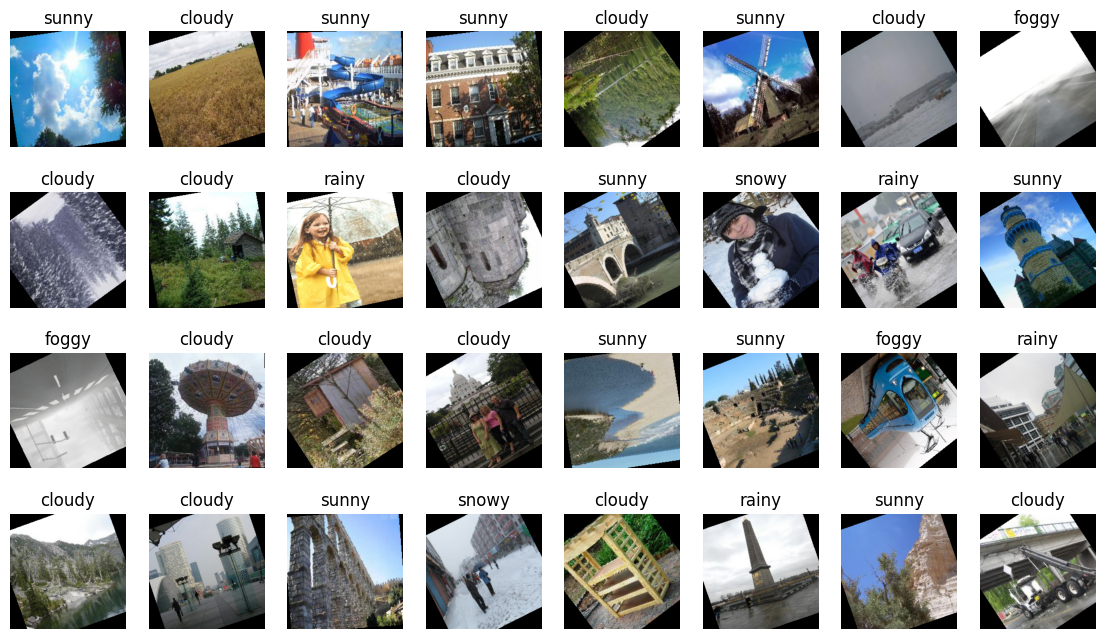

In [9]:
# mydata.showimg(using='A') # 전처리기 albumentations
mydata.showimg()          # 전처리기 pytorch

### model 설정 

In [10]:
# https://github.com/pytorch/vision/tree/6db1569c89094cf23f3bc41f79275c45e9fcb3f3/torchvision/models
model = models.resnet101(weights=True)

for parameter in model.parameters():
    parameter.requires_grad = False 
for parameter in model.fc.parameters(): # classifier bolck: fc
    parameter.requires_grad = True

model.fc = nn.Sequential(
                    nn.Linear(2048,512),
                    nn.BatchNorm1d(512),
                    nn.ReLU(),
                    nn.Dropout(0.3),
                    nn.Linear(512,5))
model.fc

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:03<00:00, 55.1MB/s]


Sequential(
  (0): Linear(in_features=2048, out_features=512, bias=True)
  (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=512, out_features=5, bias=True)
)

# resnet101, lr=0.001, batch_s=32, scheduler=ReduceLR

Epoch : 1/55....... Train Loss : 0.717 Valid Loss : 0.601 Valid Accuracy : 0.760
Epoch : 2/55....... Train Loss : 0.604 Valid Loss : 0.565 Valid Accuracy : 0.777
Epoch : 3/55....... Train Loss : 0.568 Valid Loss : 0.502 Valid Accuracy : 0.799
Epoch : 4/55....... Train Loss : 0.536 Valid Loss : 0.514 Valid Accuracy : 0.789
Epoch : 5/55....... Train Loss : 0.518 Valid Loss : 0.540 Valid Accuracy : 0.789
Epoch : 6/55....... Train Loss : 0.504 Valid Loss : 0.503 Valid Accuracy : 0.796
Epoch : 7/55....... Train Loss : 0.495 Valid Loss : 0.474 Valid Accuracy : 0.813
Epoch : 8/55....... Train Loss : 0.482 Valid Loss : 0.484 Valid Accuracy : 0.815
Epoch : 9/55....... Train Loss : 0.449 Valid Loss : 0.482 Valid Accuracy : 0.811
Epoch : 10/55....... Train Loss : 0.464 Valid Loss : 0.506 Valid Accuracy : 0.800
Epoch : 11/55....... Train Loss : 0.456 Valid Loss : 0.466 Valid Accuracy : 0.815
Epoch : 12/55....... Train Loss : 0.435 Valid Loss : 0.474 Valid Accuracy : 0.809
Epoch : 13/55....... Trai

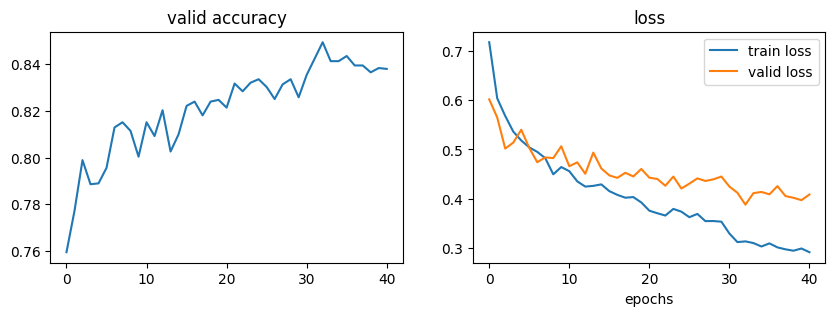

test loss: 0.405
test accuracy: 0.849
test loss: 0.404
test accuracy: 0.849
test loss: 0.413
test accuracy: 0.839


In [11]:
lr = 0.001; patience = 7; epochs = 55
model = model.to(device)
loss_fn = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=lr)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=4, verbose=True)

myNN = train(model, loss_fn, optimizer, mydata.trainloader, mydata.validloader, mydata.testloader, 
             scheduler, device, epochs, patience, batch_s)

myNN.train_loop()
myNN.result_plot()
# myNN.check(unsq=True, rnd_idx=10)
myNN.evaluation(myNN.model, myNN.testloader, myNN.loss_fn)
torch.save(myNN.model.state_dict(), 'last_checkpoint.pth')
myNN.load_model(dirct='last_checkpoint.pth', model=model)
myNN.load_model(dirct='best_checkpoint.pth', model=model)

# resnet101, lr=0.0001, batch_s=32, scheduler=ReduceLR

In [12]:
model = models.resnet101(weights=True)

for parameter in model.parameters():
    parameter.requires_grad = False 
for parameter in model.fc.parameters(): # classifier bolck: fc
    parameter.requires_grad = True

model.fc = nn.Sequential(
                    nn.Linear(2048,512),
                    nn.BatchNorm1d(512),
                    nn.ReLU(),
                    nn.Dropout(0.3),
                    nn.Linear(512,5))
model.fc

Sequential(
  (0): Linear(in_features=2048, out_features=512, bias=True)
  (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=512, out_features=5, bias=True)
)

Epoch : 1/55....... Train Loss : 0.805 Valid Loss : 0.626 Valid Accuracy : 0.764
Epoch : 2/55....... Train Loss : 0.623 Valid Loss : 0.565 Valid Accuracy : 0.772
Epoch : 3/55....... Train Loss : 0.579 Valid Loss : 0.537 Valid Accuracy : 0.792
Epoch : 4/55....... Train Loss : 0.539 Valid Loss : 0.512 Valid Accuracy : 0.793
Epoch : 5/55....... Train Loss : 0.522 Valid Loss : 0.501 Valid Accuracy : 0.800
Epoch : 6/55....... Train Loss : 0.503 Valid Loss : 0.490 Valid Accuracy : 0.806
Epoch : 7/55....... Train Loss : 0.498 Valid Loss : 0.480 Valid Accuracy : 0.814
Epoch : 8/55....... Train Loss : 0.477 Valid Loss : 0.487 Valid Accuracy : 0.806
Epoch : 9/55....... Train Loss : 0.470 Valid Loss : 0.457 Valid Accuracy : 0.817
Epoch : 10/55....... Train Loss : 0.455 Valid Loss : 0.464 Valid Accuracy : 0.817
Epoch : 11/55....... Train Loss : 0.453 Valid Loss : 0.460 Valid Accuracy : 0.810
Epoch : 12/55....... Train Loss : 0.446 Valid Loss : 0.447 Valid Accuracy : 0.827
Epoch : 13/55....... Trai

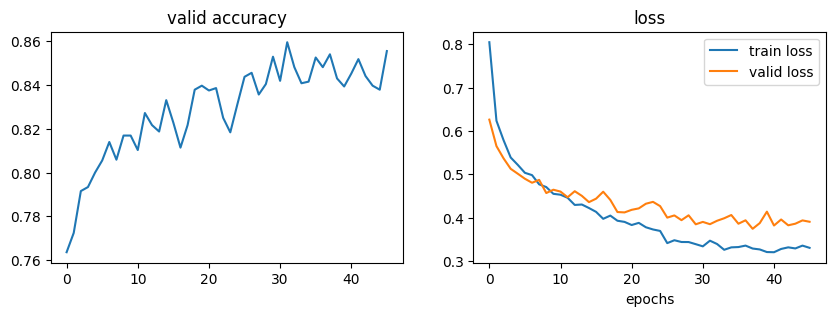

test loss: 0.401
test accuracy: 0.848
test loss: 0.401
test accuracy: 0.854
test loss: 0.399
test accuracy: 0.851


In [13]:
lr = 0.0001; patience = 7; epochs = 55
model = model.to(device)
loss_fn = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=lr)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=4, verbose=True)

myNN = train(model, loss_fn, optimizer, mydata.trainloader, mydata.validloader, mydata.testloader, 
             scheduler, device, epochs, patience, batch_s)

myNN.train_loop()
myNN.result_plot()
# myNN.check(unsq=True, rnd_idx=10)
myNN.evaluation(myNN.model, myNN.testloader, myNN.loss_fn)
torch.save(myNN.model.state_dict(), 'last_checkpoint.pth')
myNN.load_model(dirct='last_checkpoint.pth', model=model)
myNN.load_model(dirct='best_checkpoint.pth', model=model)